New

In [2]:
## written by keshavardhan reddy
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm
import math


In [4]:
class DIV2KDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, crop_size=96):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.crop_size = crop_size
        self.hr_images = sorted(os.listdir(hr_dir))
        self.lr_images = sorted(os.listdir(lr_dir))

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])

        hr = Image.open(hr_path).convert("RGB")
        lr = Image.open(lr_path).convert("RGB")

        # Center crop for training
        hr = transforms.CenterCrop(self.crop_size)(hr)
        lr = transforms.CenterCrop(self.crop_size // 2)(lr)

        hr = transforms.ToTensor()(hr)
        lr = transforms.ToTensor()(lr)
        return lr, hr


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class PatchEmbed(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, patch_size=1):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        return self.proj(x)

def window_partition(x, window_size):
    B, C, H, W = x.shape
    x = x.view(B, C, H // window_size, window_size, W // window_size, window_size)
    windows = x.permute(0, 2, 4, 3, 5, 1).contiguous().view(-1, window_size, window_size, C)
    return windows

def window_reverse(windows, window_size, H, W):
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 5, 1, 3, 2, 4).contiguous().view(B, -1, H, W)
    return x


class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads, window_size):
        super().__init__()
        self.dim = dim
        self.heads = num_heads
        self.window_size = window_size
        self.scale = (dim // num_heads) ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=True)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B_, N, C = x.shape  # B_ = batch*num_windows
        qkv = self.qkv(x).reshape(B_, N, 3, self.heads, C // self.heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)

        out = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        return self.proj(out)

class SwinTransformerBlock(nn.Module):
    def __init__(self, dim, input_resolution, num_heads, window_size=8, mlp_ratio=4.0):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.window_size = window_size

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads, window_size)

        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        B, C, H, W = x.shape
        shortcut = x

        x = x.permute(0, 2, 3, 1)  # B H W C
        x = x.view(B, H * W, C)
        x = self.norm1(x)
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)

        x_windows = window_partition(x, self.window_size)  # [num_windows*B, Ws, Ws, C]
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)
        attn_windows = self.attn(x_windows)
        x = window_reverse(attn_windows, self.window_size, H, W)

        x = x + shortcut

        x = x.permute(0, 2, 3, 1).view(B, H * W, C)
        x = self.norm2(x)
        x = self.mlp(x)
        x = x.view(B, H, W, C).permute(0, 3, 1, 2)

        return x

class RSTB(nn.Module):
    def __init__(self, dim, depth, num_heads, window_size):
        super().__init__()
        self.blocks = nn.Sequential(*[
            SwinTransformerBlock(dim, (None, None), num_heads, window_size)
            for _ in range(depth)
        ])
        self.conv = nn.Conv2d(dim, dim, kernel_size=3, padding=1)

    def forward(self, x):
        out = self.blocks(x)
        out = self.conv(out)
        return out + x

class SwinIR(nn.Module):
    def __init__(self, embed_dim=96, depths=[6], num_heads=[6], window_size=8, scale=2):
        super().__init__()
        self.shallow = PatchEmbed(in_channels=3, embed_dim=embed_dim)

        self.body = nn.Sequential(*[
            RSTB(embed_dim, depth, num_heads[i], window_size)
            for i, depth in enumerate(depths)
        ])

        self.upsample = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim * 4, 3, 1, 1),
            nn.PixelShuffle(2),
            nn.Conv2d(embed_dim, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.shallow(x)
        x = self.body(x)
        x = self.upsample(x)
        return x


In [6]:
def calc_psnr(sr, hr):
    mse = nn.functional.mse_loss(sr, hr)
    if mse == 0:
        return 100
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def train(model, train_loader, criterion, optimizer, device, num_epochs=10, save_path='swinir_best.pth'):
    best_psnr = 0.0
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for i, (lr, hr) in enumerate(loop):
            lr, hr = lr.to(device), hr.to(device)

            sr = model(lr)
            loss = criterion(sr, hr)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        model.eval()

        # Quick validation
        with torch.no_grad():
            psnr_total = 0
            samples = 0
            for lr, hr in train_loader:
                lr, hr = lr.to(device), hr.to(device)
                sr = model(lr)
                psnr_total += calc_psnr(sr, hr).item()
                samples += 1
                if samples == 10:
                    break

            avg_psnr = psnr_total / samples
            print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, PSNR: {avg_psnr:.2f}")

            if avg_psnr > best_psnr:
                best_psnr = avg_psnr
                torch.save(model.state_dict(), save_path)
                print(f"✅ Best model saved with PSNR: {best_psnr:.2f}")


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DIV2KDataset(
    lr_dir="/kaggle/input/project/DIV2K_train_LR_bicubic_X2/DIV2K_train_LR_bicubic/X2",
    hr_dir="/kaggle/input/project/DIV2K_train_HR/DIV2K_train_HR",
    crop_size=96
)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

model = SwinIR(embed_dim=96, depths=[6, 6], num_heads=[6, 6], window_size=8)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

train(model, train_loader, criterion, optimizer, device, num_epochs=25)


Epoch 1/25: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, loss=0.0586]


Epoch 1, Loss: 0.0749, PSNR: 23.40
✅ Best model saved with PSNR: 23.40


Epoch 2/25: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s, loss=0.0372]


Epoch 2, Loss: 0.0405, PSNR: 25.20
✅ Best model saved with PSNR: 25.20


Epoch 3/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0336]


Epoch 3, Loss: 0.0355, PSNR: 25.52
✅ Best model saved with PSNR: 25.52


Epoch 4/25: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.0316]


Epoch 4, Loss: 0.0325, PSNR: 25.56
✅ Best model saved with PSNR: 25.56


Epoch 5/25: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0223]


Epoch 5, Loss: 0.0333, PSNR: 25.08


Epoch 6/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0278]


Epoch 6, Loss: 0.0317, PSNR: 25.43


Epoch 7/25: 100%|██████████| 100/100 [00:46<00:00,  2.15it/s, loss=0.0264]


Epoch 7, Loss: 0.0299, PSNR: 27.46
✅ Best model saved with PSNR: 27.46


Epoch 8/25: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.03] 


Epoch 8, Loss: 0.0303, PSNR: 26.17


Epoch 9/25: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.0351]


Epoch 9, Loss: 0.0294, PSNR: 27.54
✅ Best model saved with PSNR: 27.54


Epoch 10/25: 100%|██████████| 100/100 [00:46<00:00,  2.14it/s, loss=0.0286]


Epoch 10, Loss: 0.0303, PSNR: 26.82


Epoch 11/25: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0207]


Epoch 11, Loss: 0.0295, PSNR: 28.32
✅ Best model saved with PSNR: 28.32


Epoch 12/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0298]


Epoch 12, Loss: 0.0275, PSNR: 26.74


Epoch 13/25: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.0291]


Epoch 13, Loss: 0.0274, PSNR: 28.20


Epoch 14/25: 100%|██████████| 100/100 [00:45<00:00,  2.20it/s, loss=0.0218]


Epoch 14, Loss: 0.0284, PSNR: 28.30


Epoch 15/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0406]


Epoch 15, Loss: 0.0270, PSNR: 28.07


Epoch 16/25: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.0248]


Epoch 16, Loss: 0.0268, PSNR: 27.31


Epoch 17/25: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s, loss=0.0339]


Epoch 17, Loss: 0.0271, PSNR: 27.39


Epoch 18/25: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s, loss=0.0231]


Epoch 18, Loss: 0.0271, PSNR: 27.85


Epoch 19/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0368]


Epoch 19, Loss: 0.0272, PSNR: 26.54


Epoch 20/25: 100%|██████████| 100/100 [00:46<00:00,  2.17it/s, loss=0.0256]


Epoch 20, Loss: 0.0266, PSNR: 28.36
✅ Best model saved with PSNR: 28.36


Epoch 21/25: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0392]


Epoch 21, Loss: 0.0264, PSNR: 26.91


Epoch 22/25: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s, loss=0.0261]


Epoch 22, Loss: 0.0269, PSNR: 28.69
✅ Best model saved with PSNR: 28.69


Epoch 23/25: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s, loss=0.0178]


Epoch 23, Loss: 0.0257, PSNR: 26.89


Epoch 24/25: 100%|██████████| 100/100 [00:48<00:00,  2.04it/s, loss=0.0232]


Epoch 24, Loss: 0.0268, PSNR: 29.04
✅ Best model saved with PSNR: 29.04


Epoch 25/25: 100%|██████████| 100/100 [00:51<00:00,  1.95it/s, loss=0.0252]


Epoch 25, Loss: 0.0252, PSNR: 26.79


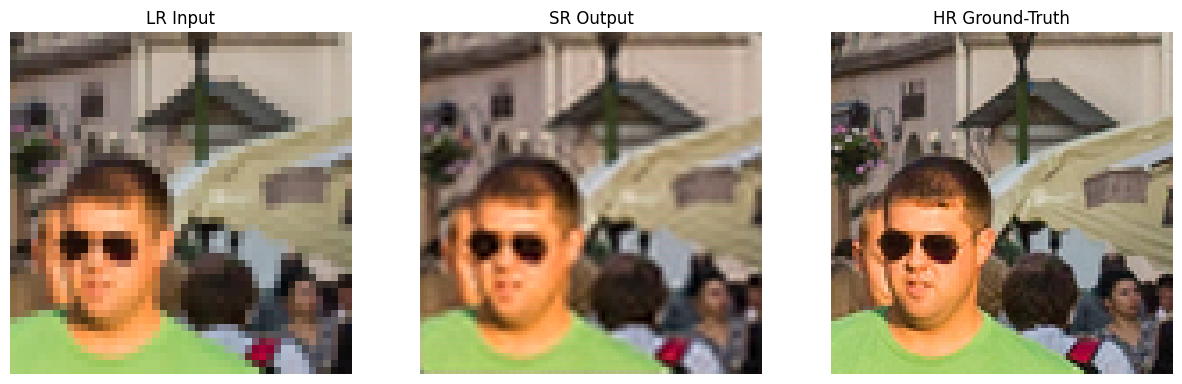

In [31]:
import matplotlib.pyplot as plt

# Grab one sample from the train_loader (or define a val_loader similarly)
model.eval()
with torch.no_grad():
    lr, hr = next(iter(train_loader))    # or val_loader
    lr, hr = lr.to(device), hr.to(device)
    sr = model(lr)

# Move to CPU & convert to numpy
lr_img = lr[0].cpu().permute(1,2,0).numpy()
sr_img = sr[0].cpu().permute(1,2,0).clamp(0,1).numpy()
hr_img = hr[0].cpu().permute(1,2,0).numpy()

# Plot
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(lr_img); axes[0].set_title("LR Input");  axes[0].axis('off')
axes[1].imshow(sr_img); axes[1].set_title("SR Output"); axes[1].axis('off')
axes[2].imshow(hr_img); axes[2].set_title("HR Ground-Truth"); axes[2].axis('off')
plt.show()


In [28]:
%%writefile dataset.py
# Paste dataset class here

%%writefile model.py
# Paste model code here


Writing dataset.py


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = DIV2KDataset(
   '/kaggle/input/paintings/512_data',
        '/kaggle/input/paintings/1024data',
    crop_size=96
)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=2)

model = SwinIR(embed_dim=96, depths=[6, 6], num_heads=[6, 6], window_size=8)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

train(model, train_loader, criterion, optimizer, device, num_epochs=25)


Epoch 1/25: 100%|██████████| 496/496 [00:58<00:00,  8.52it/s, loss=0.0176]


Epoch 1, Loss: 0.0295, PSNR: 30.42
✅ Best model saved with PSNR: 30.42


Epoch 2/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0771]


Epoch 2, Loss: 0.0194, PSNR: 30.40


Epoch 3/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0167]


Epoch 3, Loss: 0.0178, PSNR: 30.09


Epoch 4/25: 100%|██████████| 496/496 [00:56<00:00,  8.73it/s, loss=0.0276]


Epoch 4, Loss: 0.0171, PSNR: 32.50
✅ Best model saved with PSNR: 32.50


Epoch 5/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0274]


Epoch 5, Loss: 0.0166, PSNR: 32.07


Epoch 6/25: 100%|██████████| 496/496 [00:57<00:00,  8.69it/s, loss=0.0178] 


Epoch 6, Loss: 0.0169, PSNR: 33.13
✅ Best model saved with PSNR: 33.13


Epoch 7/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.00867]


Epoch 7, Loss: 0.0164, PSNR: 32.34


Epoch 8/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.011]  


Epoch 8, Loss: 0.0161, PSNR: 33.42
✅ Best model saved with PSNR: 33.42


Epoch 9/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.00807]


Epoch 9, Loss: 0.0161, PSNR: 32.56


Epoch 10/25: 100%|██████████| 496/496 [00:56<00:00,  8.73it/s, loss=0.0161]


Epoch 10, Loss: 0.0154, PSNR: 33.59
✅ Best model saved with PSNR: 33.59


Epoch 11/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.013]  


Epoch 11, Loss: 0.0152, PSNR: 33.75
✅ Best model saved with PSNR: 33.75


Epoch 12/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.0126] 


Epoch 12, Loss: 0.0150, PSNR: 33.17


Epoch 13/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0119] 


Epoch 13, Loss: 0.0154, PSNR: 33.18


Epoch 14/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0115]


Epoch 14, Loss: 0.0149, PSNR: 33.20


Epoch 15/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.0117]


Epoch 15, Loss: 0.0152, PSNR: 33.82
✅ Best model saved with PSNR: 33.82


Epoch 16/25: 100%|██████████| 496/496 [00:56<00:00,  8.73it/s, loss=0.0284] 


Epoch 16, Loss: 0.0143, PSNR: 33.18


Epoch 17/25: 100%|██████████| 496/496 [00:59<00:00,  8.28it/s, loss=0.0114] 


Epoch 17, Loss: 0.0141, PSNR: 34.24
✅ Best model saved with PSNR: 34.24


Epoch 18/25: 100%|██████████| 496/496 [00:56<00:00,  8.73it/s, loss=0.0182]


Epoch 18, Loss: 0.0144, PSNR: 33.92


Epoch 19/25: 100%|██████████| 496/496 [00:59<00:00,  8.27it/s, loss=0.0152] 


Epoch 19, Loss: 0.0140, PSNR: 34.55
✅ Best model saved with PSNR: 34.55


Epoch 20/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0159] 


Epoch 20, Loss: 0.0140, PSNR: 33.79


Epoch 21/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.0142] 


Epoch 21, Loss: 0.0143, PSNR: 34.26


Epoch 22/25: 100%|██████████| 496/496 [00:56<00:00,  8.72it/s, loss=0.00763]


Epoch 22, Loss: 0.0137, PSNR: 34.53


Epoch 23/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.00884]


Epoch 23, Loss: 0.0136, PSNR: 33.81


Epoch 24/25: 100%|██████████| 496/496 [00:56<00:00,  8.73it/s, loss=0.0104] 


Epoch 24, Loss: 0.0136, PSNR: 35.38
✅ Best model saved with PSNR: 35.38


Epoch 25/25: 100%|██████████| 496/496 [00:56<00:00,  8.71it/s, loss=0.0141] 


Epoch 25, Loss: 0.0137, PSNR: 34.98


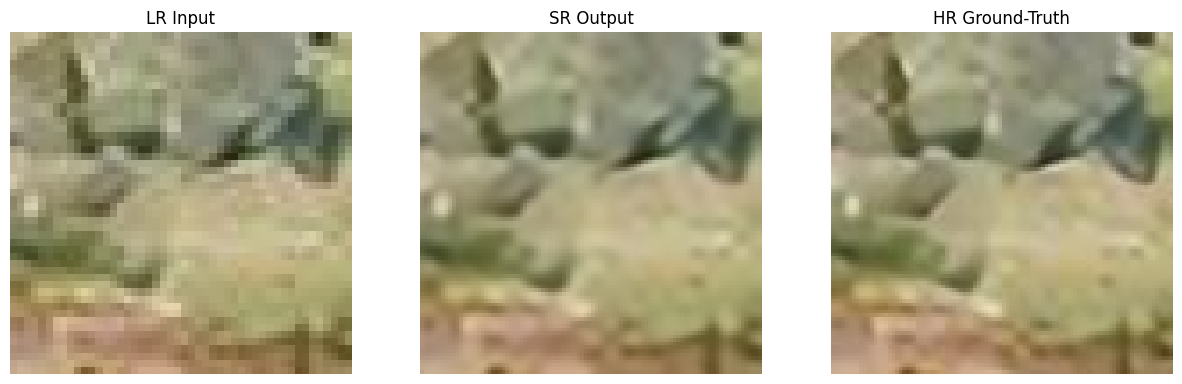

In [8]:
import matplotlib.pyplot as plt

# Grab one sample from the train_loader (or define a val_loader similarly)
model.eval()
with torch.no_grad():
    lr, hr = next(iter(train_loader))    # or val_loader
    lr, hr = lr.to(device), hr.to(device)
    sr = model(lr)

# Move to CPU & convert to numpy
lr_img = lr[0].cpu().permute(1,2,0).numpy()
sr_img = sr[0].cpu().permute(1,2,0).clamp(0,1).numpy()
hr_img = hr[0].cpu().permute(1,2,0).numpy()

# Plot
fig, axes = plt.subplots(1,3, figsize=(15,5))
axes[0].imshow(lr_img); axes[0].set_title("LR Input");  axes[0].axis('off')
axes[1].imshow(sr_img); axes[1].set_title("SR Output"); axes[1].axis('off')
axes[2].imshow(hr_img); axes[2].set_title("HR Ground-Truth"); axes[2].axis('off')
plt.show()
